# Metode Multinomial Naive Bayes

## Import Libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter

import pandas as pd
import pandas.io.formats.html
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import warnings
import nltk

warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download("punkt")
nltk.download('punkt_tab') 
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset Config

In [2]:
DATASET_DIR = "smsa_doc-sentiment-prosa"

In [3]:
df_train = pd.read_csv(f"{DATASET_DIR}/train_preprocess.tsv", sep="\t", header=None)
df_valid = pd.read_csv(f"{DATASET_DIR}/valid_preprocess.tsv", sep="\t", header=None)
df_test_unmasked = pd.read_csv(f"{DATASET_DIR}/test_preprocess.tsv", sep="\t", header=None)
df_test_masked = pd.read_csv(f"{DATASET_DIR}/test_preprocess_masked_label.tsv", sep="\t", header=None)

with open(f"{DATASET_DIR}/vocab_uncased.txt", "r") as f:
    vocab = f.read().splitlines()

In [4]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.sample(n=10, random_state=1)

,text,emotion
7030,"dapat rekomendasi makan di sini dari teman , k...",positive
2095,aduh pak tak usah kau marah-marah tak jelas be...,negative
7168,tempat nya walaupun kecil tapi cocok untuk mak...,positive
7969,paling juara desert di sini . beragam pilihan ...,positive
6320,zionis adalah bangsa paling sombong sekaligus ...,negative
6136,makanan di sini tidak pernah mengecewakan . se...,positive
4687,bangga banget punya pak jokowi sebagai preside...,positive
9934,wow ini indomie keju nya banyak amat sampai su...,positive
7868,saya biasanya menonton channel global tv,neutral
4865,walau aku suka pamer 2 jari tapi hati aku tida...,positive


In [5]:
df_valid.sample(n=10, random_state=1)

,text,emotion
1179,tidak amburadul,positive
255,"ini foton pakai handphone xiaomi note 4 , tamp...",negative
304,baru kali ini saya menikmati makanan sunda . s...,positive
403,bagi penggemar kopi susu mampirlah ke sini . a...,positive
75,kita makan di sini karena terjebak macet dan s...,positive
119,"bagus tempat , bagus makanan . pokok nya tidak...",positive
912,gue enggak mau jadi ikutan goblok seperti yang...,negative
1073,nikmati mi ayam atau mi chai shu yang enak di ...,positive
496,customer service indohome tidak pernah gagal d...,positive
1161,di valley kami sekeluarga sangat senang meliha...,positive


In [6]:
df_test_unmasked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,negative
340,artis cowok pop banci semua .,negative
47,aplikasi tipu . sialan . mengembalikan duit gu...,negative
67,udahlah kecewa jakarta dapet nya anies - sandi...,negative
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",negative
31,"saya hilang 2.5 juta dari apa ini karena , ter...",negative
249,pengiriman barang menggunakan jne sangat memua...,positive
90,"menyesal tidak sih ganti handphone , dari ipho...",negative


In [7]:
df_test_masked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,neutral
340,artis cowok pop banci semua .,neutral
47,aplikasi tipu . sialan . mengembalikan duit gu...,neutral
67,udahlah kecewa jakarta dapet nya anies - sandi...,neutral
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",neutral
31,"saya hilang 2.5 juta dari apa ini karena , ter...",neutral
249,pengiriman barang menggunakan jne sangat memua...,neutral
90,"menyesal tidak sih ganti handphone , dari ipho...",neutral


## Preprocessing

In [8]:
def to_lowercase(text):
    return text.lower()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens]
    return ' '.join(tokens)

In [9]:
df_train['text'] = df_train['text'].apply(to_lowercase)
df_valid['text'] = df_valid['text'].apply(to_lowercase)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(to_lowercase)
df_test_masked['text'] = df_test_masked['text'].apply(to_lowercase)

df_train['text'] = df_train['text'].apply(tokenize)
df_valid['text'] = df_valid['text'].apply(tokenize)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize)

In [10]:
df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


## Exploratory Data Analysis

C:\Users\User\AppData\Local\Temp/ipykernel_5892/3760294676.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)


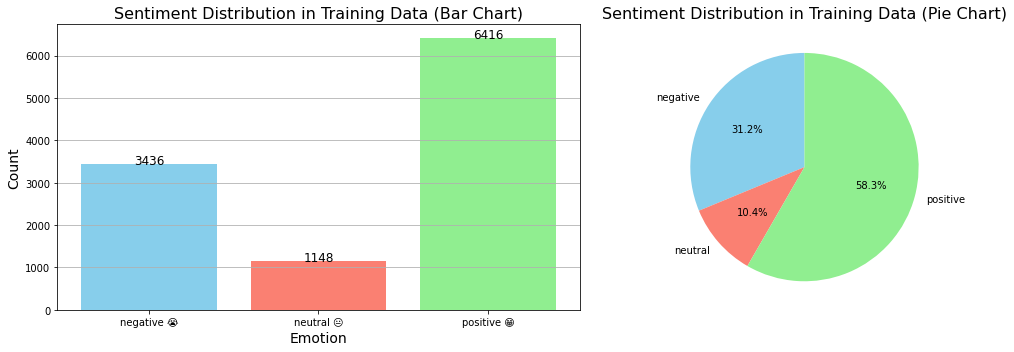

emotion
negative    3436
neutral     1148
positive    6416
Name: text, dtype: int64


In [11]:
emotion_emoticons = {
    'positive': '😁',
    'negative': '😭',
    'neutral': '😐'
}

emotion_counts = df_train.groupby('emotion').text.count()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(emotion_counts.index, emotion_counts, color=['skyblue', 'salmon', 'lightgreen'])
axs[0].set_title("Sentiment Distribution in Training Data (Bar Chart)", fontsize=16)
axs[0].set_xlabel("Emotion", fontsize=14)
axs[0].set_ylabel("Count", fontsize=14)
axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)
axs[0].yaxis.grid(True)

for i, count in enumerate(emotion_counts):
    axs[0].text(i, count + 0.5, str(count), ha='center', fontsize=12)

emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'lightgreen'], ax=axs[1])
axs[1].set_title("Sentiment Distribution in Training Data (Pie Chart)", fontsize=16)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(emotion_counts)

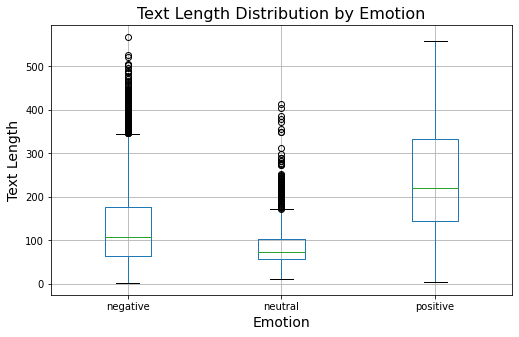

In [12]:
df_train['text_length'] = df_train['text'].apply(len)

fig, ax = plt.subplots(figsize=(8, 5))
df_train.boxplot(column='text_length', by='emotion', ax=ax)
ax.set_title("Text Length Distribution by Emotion", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Text Length", fontsize=14)
plt.suptitle('')
plt.show()


C:\Users\User\AppData\Local\Temp/ipykernel_5892/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)


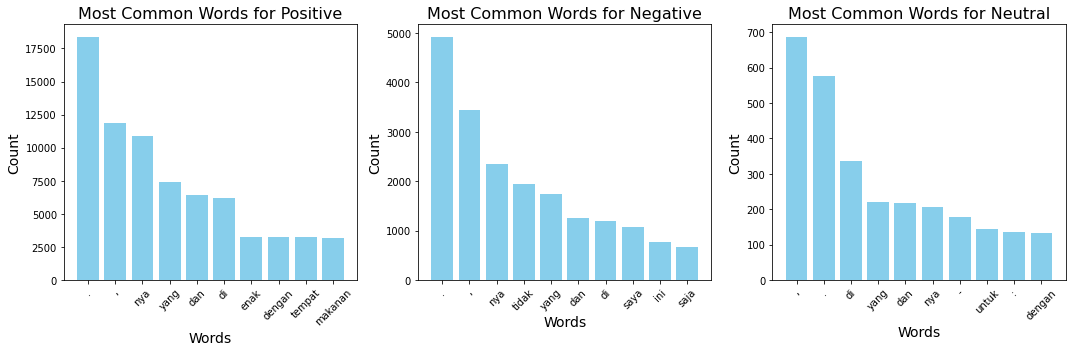

In [13]:
def common_words(emotion):
    words = ' '.join(df_train[df_train['emotion'] == emotion]['text']).split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return Counter(words).most_common(10)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, emotion in zip(axs, emotion_emoticons.keys()):
    common = common_words(emotion)
    words, counts = zip(*common)
    ax.bar(words, counts, color=['skyblue'] * len(words))
    ax.set_title(f'Most Common Words for {emotion.capitalize()}', fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()


## Traning Preparation

 ### Encode Emotion Column

In [14]:
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

### Train and Validation

In [15]:
cleaned_vocab = [string.strip() for string in vocab if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

### Report and Visualizer

In [16]:
def class_report_validation(y_valid, y_valid_pred):
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f"Accuracy\t: {accuracy}")
  print(f'Precision\t: {precision}')
  print(f'Recall\t\t: {recall}')
  print(f'F1-Score\t: {f1}\n')

  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy = accuracy_score(y_test, y_test_pred)
  precision = precision_score(y_test, y_test_pred, average='macro')
  recall = recall_score(y_test, y_test_pred, average='macro')
  f1 = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy\t: {accuracy}')
  print(f'Test Precision\t: {precision}')
  print(f'Test Recall\t: {recall}')
  print(f'Test F1-Score\t: {f1}\n')

  print(classification_report(y_test, y_test_pred, target_names=['negative', 'neutral', 'positive']))

def visualize_misclassifications(df_test_unmasked, y_test_pred, kernel):
    df_test_unmasked['predicted_emotion'] = y_test_pred
    misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]

    misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
    total_count = df_test_unmasked.shape[0]
    misclassified_percentage = (misclassified_count / total_count) * 100

    print(f'Banyak data yang salah diprediksi: {misclassified_count} ({misclassified_percentage:.2f}%)')

    emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
    misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
    misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)

    misclassified_counts = misclassified.groupby('emotion').size()

    emotion_emoticons = {
        'positive': '😁',
        'negative': '😭',
        'neutral': '😐'
    }

    fig, ax = plt.subplots(figsize=(8, 5))
    misclassified_counts.plot(kind='bar', color=['salmon', 'lightblue', 'lightgreen'], ax=ax)

    ax.set_title(f"Misclassification Distribution for Alpha={kernel}", fontsize=16)
    ax.set_xlabel('True Emotions', fontsize=14)
    ax.set_ylabel('Count of Misclassifications', fontsize=14)

    ax.set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in misclassified_counts.index], rotation=0)

    for i, count in enumerate(misclassified_counts):
        ax.text(i, count + 0.5, str(count), ha='center', fontsize=12)

    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nExamples of Misclassifications:")
    misclassified_samples = misclassified[['text', 'emotion', 'predicted_emotion']].sample(n=5, random_state=1)

    for index, row in misclassified_samples.iterrows():
        true_emotion_emoticon = emotion_emoticons[row['emotion']]
        predicted_emotion_emoticon = emotion_emoticons[row['predicted_emotion']]
        print(f"Text: {row['text']}")
        print(f"  True Emotion: {row['emotion']} {true_emotion_emoticon}")
        print(f"  Predicted Emotion: {row['predicted_emotion']} {predicted_emotion_emoticon}")
        print('-' * 80)


## Experiment 1 : Default Alpha (1.0)

In [17]:
clf_model = MultinomialNB()
clf_model.fit(X_train, y_train)

MultinomialNB()

### Validation

In [18]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8595238095238096
Precision	: 0.8552950683978678
Recall		: 0.8079622352809585
F1-Score	: 0.826914012098952

              precision    recall  f1-score   support

    negative       0.79      0.85      0.81       394
     neutral       0.88      0.68      0.77       131
    positive       0.90      0.90      0.90       735

    accuracy                           0.86      1260
   macro avg       0.86      0.81      0.83      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [19]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.63
Test Precision	: 0.7001435017243732
Test Recall	: 0.5678161707573472
Test F1-Score	: 0.5677142860772925

              precision    recall  f1-score   support

    negative       0.56      0.97      0.71       204
     neutral       0.74      0.30      0.42        88
    positive       0.79      0.44      0.57       208

    accuracy                           0.63       500
   macro avg       0.70      0.57      0.57       500
weighted avg       0.69      0.63      0.60       500



### Misclassified

Banyak data yang salah diprediksi: 185 (37.00%)


C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


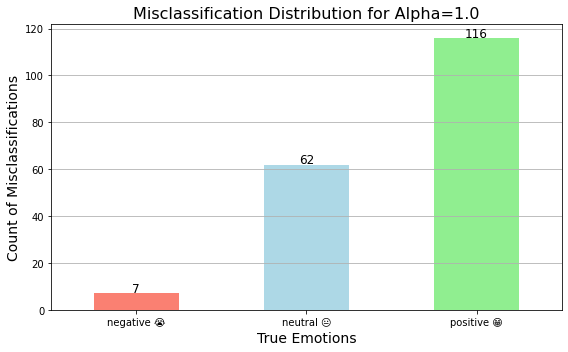


Examples of Misclassifications:
Text: tidak dapat apple aku tidak kecewa kok . yang penting samsung galaxy grand sudah di tangan ku sekarang . aku senang .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: di sekitar istana bogor , kita bisa kasih makan rusa langsung kalau rusa-rusa nya lagi dikeluarkan .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: mantap bu saya juga akan ikut ke pantai bu . biar laut kita bersih , kalau kotor nanti malah ditenggelamkan dengan bu susi . hehehe .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: sumpah big cola jauh banget lebih enak daripada coca cola ! tidak terlalu manis dan tidak menyisakan pait di mulut seperti coke zero . wkwk norak ya gue baru mencoba . tap

In [20]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "1.0")

## Experiment 2 : Alpha 0

In [21]:
clf_model = MultinomialNB(alpha=0)
clf_model.fit(X_train, y_train)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


MultinomialNB(alpha=0)

### Validation

In [22]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.5825396825396826
Precision	: 0.6932772537236254
Recall		: 0.4990111754909789
F1-Score	: 0.4644932901747823

              precision    recall  f1-score   support

    negative       0.43      0.90      0.58       394
     neutral       0.76      0.10      0.18       131
    positive       0.89      0.50      0.64       735

    accuracy                           0.58      1260
   macro avg       0.69      0.50      0.46      1260
weighted avg       0.73      0.58      0.57      1260



### Test

In [23]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.482
Test Precision	: 0.5326111487248929
Test Recall	: 0.4009923899629782
Test F1-Score	: 0.34016429029300516

              precision    recall  f1-score   support

    negative       0.45      0.94      0.61       204
     neutral       0.50      0.05      0.08        88
    positive       0.64      0.22      0.32       208

    accuracy                           0.48       500
   macro avg       0.53      0.40      0.34       500
weighted avg       0.54      0.48      0.40       500



### Misclassified

Banyak data yang salah diprediksi: 259 (51.80%)


C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


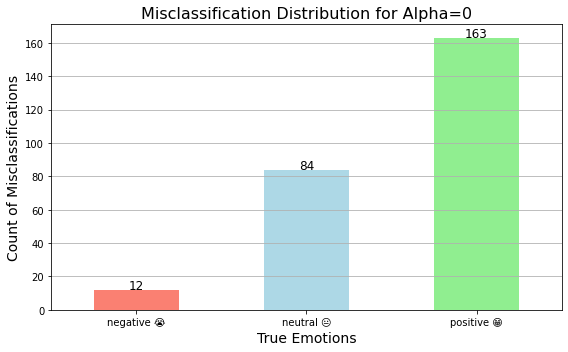


Examples of Misclassifications:
Text: aku dukung banget kerja sama antara jokowi sama dengan ruf amin , insyaallah indonesia bisa lebih baik ke depan nya kalau sama mereka .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: terima kasih untuk buah karya mu di jakarta yang jadi sejuk santun bersama pak sandi juga pak anies
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: laptop lenovo nomor 1 sih buat gue .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: sudah hampir 350 orang yang meninggal karena gempa di lombok kemarin .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: gojek fitur nya makin banyak .
  T

In [24]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "0")

## Experiment 3 : Alpha 0.5

In [25]:
clf_model = MultinomialNB(alpha=0.5)
clf_model.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

### Validation

In [26]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8579365079365079
Precision	: 0.8411626743611421
Recall		: 0.8212997985130684
F1-Score	: 0.8297339227254548

              precision    recall  f1-score   support

    negative       0.78      0.84      0.81       394
     neutral       0.83      0.73      0.78       131
    positive       0.91      0.89      0.90       735

    accuracy                           0.86      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [27]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.624
Test Precision	: 0.6694385416767741
Test Recall	: 0.5805224187577128
Test F1-Score	: 0.5729130542698603

              precision    recall  f1-score   support

    negative       0.57      0.97      0.72       204
     neutral       0.63      0.39      0.48        88
    positive       0.81      0.38      0.52       208

    accuracy                           0.62       500
   macro avg       0.67      0.58      0.57       500
weighted avg       0.68      0.62      0.59       500



### Misclassified

Banyak data yang salah diprediksi: 188 (37.60%)


C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


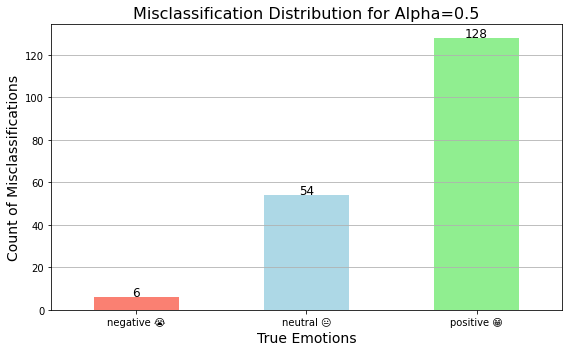


Examples of Misclassifications:
Text: terima kasih untuk buah karya mu di jakarta yang jadi sejuk santun bersama pak sandi juga pak anies
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: kemarin itu pertama kalinya mencoba fatmilo yang white milo . demi apa pun itu enak banget sih ampun aku itu tidak bisa berkata-berkata lagi ! enak banget , selera gue bangetlah !
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: buat indonesia apa sih yang tidak , gue rela deh kayak pahlawan zaman dulu yang sampai mengorbankan nyawa .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: tidak usah ditanya kehebatan jokowi apa , semua juga bisa dilakukan sama bapak presiden terkuat satu itu .
  True Emotion: positive 😁
 

In [28]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "0.5")

## Experiment 4 : Hyperparameter Tuning

In [36]:
def evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid):
    parameters = {'alpha': [0.01, 0.5, 1], 'force_alpha': [True, False]}

    grid_search = GridSearchCV(MultinomialNB(), parameters, scoring='f1_macro', refit=True)
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)

    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
    print("Top Grid Search Results:")
    print(sorted_results[['param_alpha', 'param_force_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

    fig, ax = plt.subplots(figsize=(10, 6))

    pivot_table = results_df.pivot_table(index='param_alpha', columns='param_force_alpha', values='mean_test_score')
    pivot_table.plot(kind='bar', ax=ax)
    
    ax.set_title('Comparison of Multinomial NB Alpha and Force Alpha values based on F1-Score', fontsize=16)
    ax.set_xlabel('C Values', fontsize=14)
    ax.set_ylabel('Mean F1-Score', fontsize=14)
    ax.legend(title="Kernel", fontsize=12)

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f"\nBest model: {best_model}")
    print(f"Best cross-validation score (F1-macro): {best_score:.4f}")

    y_valid_pred = best_model.predict(X_valid)

    print("\nEvaluation on validation set complete.")

Top Grid Search Results:
  param_alpha param_force_alpha  mean_test_score  std_test_score  \
2         0.5              True         0.818335        0.014931   
3         0.5             False         0.818335        0.014931   
0        0.01              True         0.810302        0.007830   
1        0.01             False         0.810302        0.007830   
4           1              True         0.805364        0.009229   

   rank_test_score  
2                1  
3                1  
0                3  
1                3  
4                5  


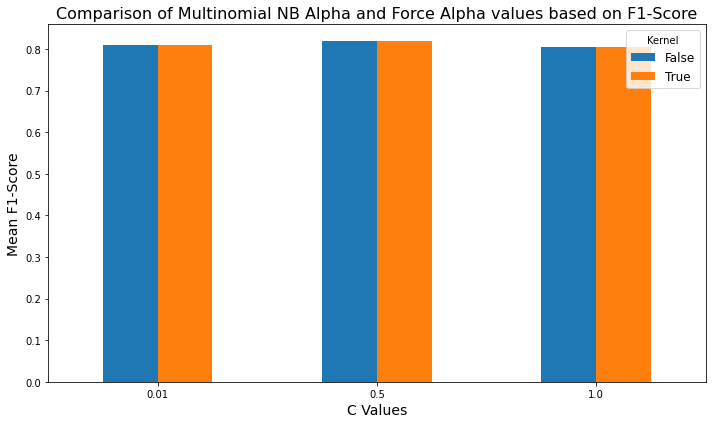


Best model: MultinomialNB(alpha=0.5)
Best cross-validation score (F1-macro): 0.8183

Evaluation on validation set complete.


In [37]:
evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid)

In [42]:
clf_model = MultinomialNB(alpha=0.5, force_alpha=True)
clf_model.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

### Validation

In [43]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8579365079365079
Precision	: 0.8411626743611421
Recall		: 0.8212997985130684
F1-Score	: 0.8297339227254548

              precision    recall  f1-score   support

    negative       0.78      0.84      0.81       394
     neutral       0.83      0.73      0.78       131
    positive       0.91      0.89      0.90       735

    accuracy                           0.86      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [44]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.624
Test Precision	: 0.6694385416767741
Test Recall	: 0.5805224187577128
Test F1-Score	: 0.5729130542698603

              precision    recall  f1-score   support

    negative       0.57      0.97      0.72       204
     neutral       0.63      0.39      0.48        88
    positive       0.81      0.38      0.52       208

    accuracy                           0.62       500
   macro avg       0.67      0.58      0.57       500
weighted avg       0.68      0.62      0.59       500



### Misclassified

Banyak data yang salah diprediksi: 188 (37.60%)


C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_5892/1602529295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


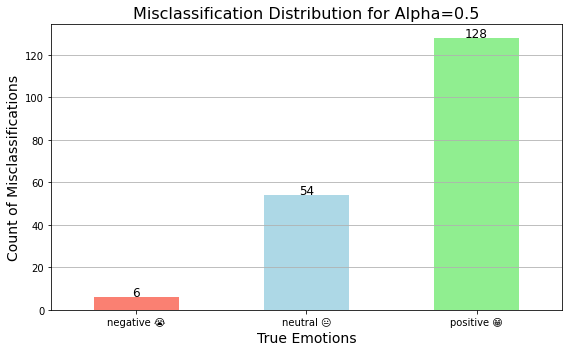


Examples of Misclassifications:
Text: terima kasih untuk buah karya mu di jakarta yang jadi sejuk santun bersama pak sandi juga pak anies
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: kemarin itu pertama kalinya mencoba fatmilo yang white milo . demi apa pun itu enak banget sih ampun aku itu tidak bisa berkata-berkata lagi ! enak banget , selera gue bangetlah !
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: buat indonesia apa sih yang tidak , gue rela deh kayak pahlawan zaman dulu yang sampai mengorbankan nyawa .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: tidak usah ditanya kehebatan jokowi apa , semua juga bisa dilakukan sama bapak presiden terkuat satu itu .
  True Emotion: positive 😁
 

In [45]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "0.5")